# Problem Statement: Business Scenario and Hypotheses

AAVAIL launched a tiered, subscription-based service which showed promise, but conversations with users, especially those outside of US markets, prompted an experiment using an à la carte approach. This experiment was carried out mostly outside of the US and there are now a couple of years of data with a few thousand active users. The data are transaction-level purchases across 38 different countries and are invoiced in batches. Management is facing chanllenges to predict monthly revenue accurately.

Management currently has siloed semi-automatic method to forecast revenue is looking for ability to predict the revenue for the following month at any point in time for all or a specific country.


Null Hypotheses: The ML alogorithms are not acccurate than existing siloed semi-automatic method.

# Data requirements

The minimal data needed are revenue, number of times the steam is viewed, location and date. 


# Exploratory Data Analysis

In [33]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

## specify the directory you saved the data and images in
DATA_DIR = os.path.join("..","data")
IMAGE_DIR = os.path.join("..","images")

COLORS = ["darkorange","royalblue","slategrey"]

In [34]:
def fetch_data(data_dir):

    ## input testing
    #if not os.path.isdir(data_dir):
    #    raise Exception("specified data dir does not exist")
    #if not len(os.listdir(data_dir)) > 0:
    #    raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)

In [35]:
data_dir = os.path.join("..","data","cs-train")
df = fetch_data(data_dir)

In [36]:
df.head(5)

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,17998.0,28,489562,11,5.95,84656,1,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [37]:
df.shape

(815011, 10)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815011 entries, 0 to 815010
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       815011 non-null  object        
 1   customer_id   625249 non-null  float64       
 2   day           815011 non-null  int64         
 3   invoice       815011 non-null  object        
 4   month         815011 non-null  int64         
 5   price         815011 non-null  float64       
 6   stream_id     815011 non-null  object        
 7   times_viewed  815011 non-null  int64         
 8   year          815011 non-null  int64         
 9   invoice_date  815011 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 62.2+ MB


In [39]:
print(df.isna().sum())

country              0
customer_id     189762
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64


In [40]:
#top ten countries with the most revenue
df_top10 = df.groupby('country').price.sum().nlargest(10).reset_index()
df_top10=df_top10.rename(columns = {'price':'rev_by_country'})
df_top10

,country,rev_by_country
0,United Kingdom,3.521514e+06
1,EIRE,1.070692e+05
2,Germany,4.927182e+04
3,France,4.056514e+04
4,Norway,3.849475e+04
5,Spain,1.604099e+04
6,Hong Kong,1.445257e+04
7,Portugal,1.352867e+04
8,Singapore,1.317592e+04
9,Netherlands,1.232280e+04


In [41]:
ndf = pd.merge(df_top10, df, on='country', how='inner')
ndf.head(10)

,country,rev_by_country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,3.521514e+06,17998.0,28,489562,11,5.95,84656,1,2017,2017-11-28
1,United Kingdom,3.521514e+06,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,3.521514e+06,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,3.521514e+06,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,3.521514e+06,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28
5,United Kingdom,3.521514e+06,13085.0,28,489434,11,1.25,21871,14,2017,2017-11-28
6,United Kingdom,3.521514e+06,13085.0,28,489434,11,5.95,21523,10,2017,2017-11-28
7,United Kingdom,3.521514e+06,13085.0,28,489435,11,2.55,22350,12,2017,2017-11-28
8,United Kingdom,3.521514e+06,13085.0,28,489435,11,3.75,22349,12,2017,2017-11-28
9,United Kingdom,3.521514e+06,13085.0,28,489435,11,1.65,22195,18,2017,2017-11-28


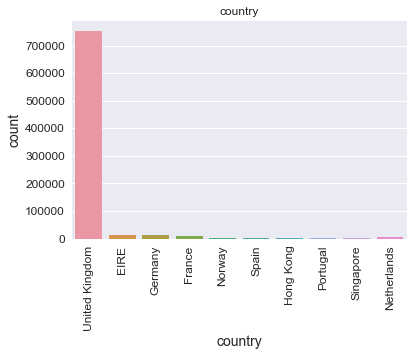

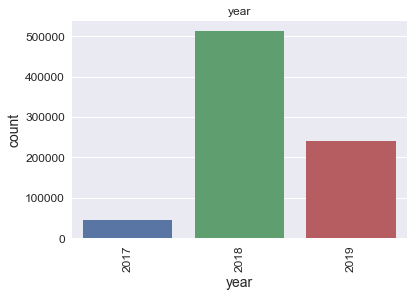

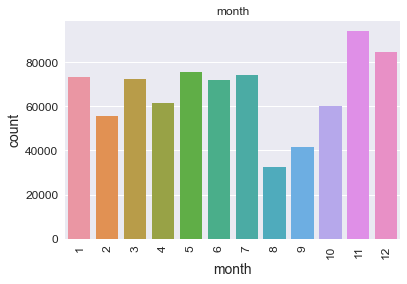

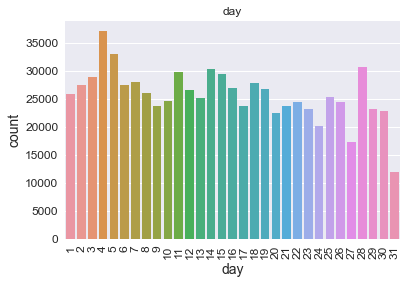

In [42]:
for col in ['country','year','month','day']:
    sns.countplot(ndf[col])
    plt.title(col)
    plt.xticks(rotation=90)
    plt.show()

# Observations:

The counts by country plot shows that UK has the very high count comparared to rest of the countries, followed by ERIE, Germany and France. 

Year 2018 has the highest counts, above 500000 and year 2017 has lowest, below 100000. 

The montly count shows August and Sepember months with lower numbers and November, December months with highest counts.

Daily count shows that the 4th day of the month has the highest count, over 35000 and later days in the month with lower counts. 31st day of the month show lowest count as Month don't have the 31st day. 

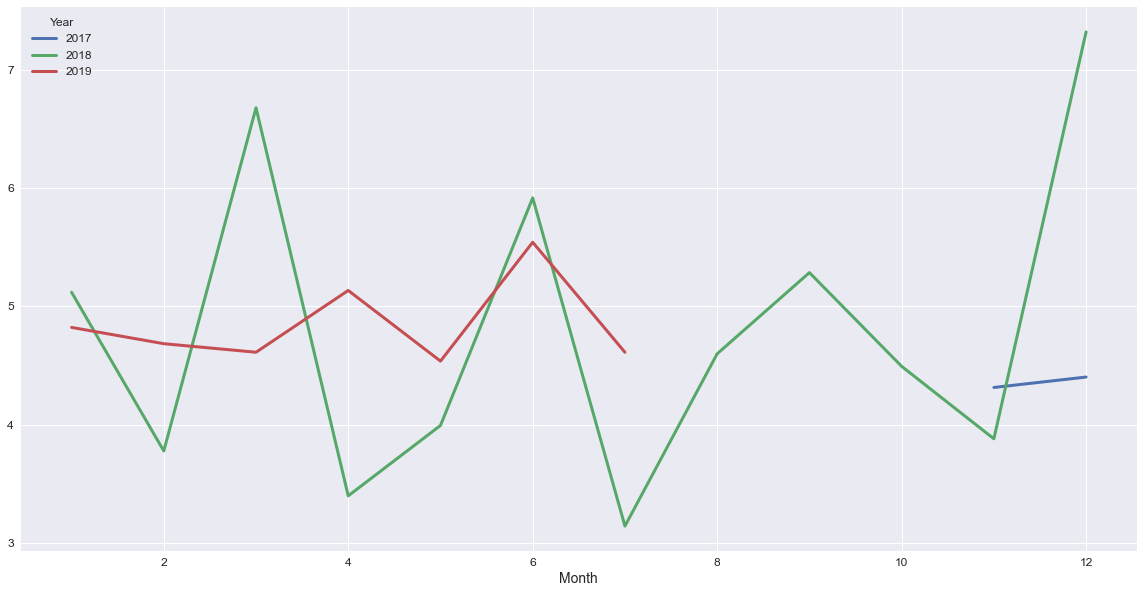

In [43]:
season = ndf
season['Year'] = ndf.year
season['Month'] = ndf.month
spivot = pd.pivot_table(season, index='Month', columns = 'Year', values = 'price', aggfunc=np.mean)
spivot.plot(figsize=(20,10), linewidth=3)
plt.show()

From above graph, we can see that the data is continuous for year 2018 only, 2019 has data till July and 2017 has data for only November and December months. For year 2018, the average price peaks in december and are relatively high in March and June, and lower in April and July.

In [44]:
#create copy of the dataframe
df_test = ndf.copy()

In [45]:
# Function to generate Timeseries data by day
def convert_to_ts(df_orig, country=None):

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    ## use a date range to ensure all days are accounted for in the data
    invoice_dates = df['invoice_date'].values
    start_month = '{}-{}'.format(df['year'].values[0],str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1],str(df['month'].values[-1]).zfill(2))
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    days = np.arange(start_month,stop_month,dtype='datetime64[D]')
    
    purchases = np.array([np.where(df_dates==day)[0].size for day in days])
    invoices = [np.unique(df[df_dates==day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates==day]['stream_id'].values).size for day in days]
    views =  [df[df_dates==day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates==day]['price'].values.sum() for day in days]
    year_month = ["-".join(re.split("-",str(day))[:2]) for day in days]

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
    return(df_time)


In [47]:
df1 = convert_to_ts(ndf)
df1.shape

(607, 7)

In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             607 non-null    datetime64[ns]
 1   purchases        607 non-null    int64         
 2   unique_invoices  607 non-null    int64         
 3   unique_streams   607 non-null    int64         
 4   total_views      607 non-null    int64         
 5   year_month       607 non-null    object        
 6   revenue          607 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 33.3+ KB


In [49]:
df1.tail(10)

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
597,2019-06-21,1021,62,645,6251,2019-06,15174.78
598,2019-06-22,0,0,0,0,2019-06,0.00
599,2019-06-23,681,35,537,2487,2019-06,2496.93
600,2019-06-24,1182,61,724,5152,2019-06,4679.18
601,2019-06-25,1043,84,647,6805,2019-06,5266.54
602,2019-06-26,1354,65,997,6411,2019-06,4864.67
603,2019-06-27,1580,77,925,9085,2019-06,5381.21
604,2019-06-28,1014,69,604,5418,2019-06,3523.05
605,2019-06-29,0,0,0,0,2019-06,0.00
606,2019-06-30,602,27,423,2534,2019-06,1793.98
